In [4]:
# Read data and aggregate into monthly sale_cnt and avg_price

import pandas as pd

train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
# columns: date, date_block_num, shop_id, item_id, item_price, item_cnt_day
train_monthly_df = train_df.groupby(['date_block_num','shop_id','item_id']).agg(item_cnt_month=('item_cnt_day','sum'), price_avg_month=('item_price','mean')).reset_index()
train_monthly_df['shop_item'] = train_monthly_df['shop_id'].astype('string') + '-' + train_monthly_df['item_id'].astype('string')

shop_item_list = pd.unique(train_monthly_df['shop_item'])
print("cnt of shop_item:",len(shop_item_list))
print('max shop id:', max(train_monthly_df.shop_id))
print('max item id:', max(train_monthly_df.item_id))
train_monthly_df

cnt of shop_item: 424124
max shop id: 59
max item id: 22169


,date_block_num,shop_id,item_id,item_cnt_month,price_avg_month,shop_item
0,0,0,32,6.0,221.0,0-32
1,0,0,33,3.0,347.0,0-33
2,0,0,35,1.0,247.0,0-35
3,0,0,43,1.0,221.0,0-43
4,0,0,51,2.0,128.5,0-51
...,...,...,...,...,...,...
1609119,33,59,22087,6.0,119.0,59-22087
1609120,33,59,22088,2.0,119.0,59-22088
1609121,33,59,22091,1.0,179.0,59-22091
1609122,33,59,22100,1.0,629.0,59-22100


In [5]:
# get the avg_price of each shop_item as default price value
shopitem_price_df = train_monthly_df.groupby(['shop_item']).agg(price=('price_avg_month','mean'))
shopitem_price_dict = {}
for idx, row in shopitem_price_df.iterrows():
    shopitem_price_dict[idx] = row['price']
len(shopitem_price_dict)

424124

In [6]:
# get the sequence of each shop_item

import numpy as np

data_seq_dict = {}
for shop_item in shop_item_list:
    shop_id = float(shop_item.split('-')[0])
    item_id = float(shop_item.split('-')[1])
    data_seq_dict[shop_item] = [[0.0, shopitem_price_dict[shop_item], shop_id, item_id, float(i%12)] for i in range(0,34)]
for _, row in train_monthly_df.iterrows():
    data_seq_dict[row['shop_item']][int(row['date_block_num'])][0] = row['item_cnt_month']
    data_seq_dict[row['shop_item']][int(row['date_block_num'])][1] = row['price_avg_month']

data_seq_array = np.array(list(data_seq_dict.values()))
print(data_seq_array.shape)  # (424124, 34, 5)
print(data_seq_array)  # (sales_cnt, price, shop_id, item_id, month)

(424124, 34, 5)
[[[6.0000e+00 2.2100e+02 0.0000e+00 3.2000e+01 0.0000e+00]
  [1.0000e+01 2.2100e+02 0.0000e+00 3.2000e+01 1.0000e+00]
  [0.0000e+00 2.2100e+02 0.0000e+00 3.2000e+01 2.0000e+00]
  ...
  [0.0000e+00 2.2100e+02 0.0000e+00 3.2000e+01 7.0000e+00]
  [0.0000e+00 2.2100e+02 0.0000e+00 3.2000e+01 8.0000e+00]
  [0.0000e+00 2.2100e+02 0.0000e+00 3.2000e+01 9.0000e+00]]

 [[3.0000e+00 3.4700e+02 0.0000e+00 3.3000e+01 0.0000e+00]
  [3.0000e+00 3.4700e+02 0.0000e+00 3.3000e+01 1.0000e+00]
  [0.0000e+00 3.4700e+02 0.0000e+00 3.3000e+01 2.0000e+00]
  ...
  [0.0000e+00 3.4700e+02 0.0000e+00 3.3000e+01 7.0000e+00]
  [0.0000e+00 3.4700e+02 0.0000e+00 3.3000e+01 8.0000e+00]
  [0.0000e+00 3.4700e+02 0.0000e+00 3.3000e+01 9.0000e+00]]

 [[1.0000e+00 2.4700e+02 0.0000e+00 3.5000e+01 0.0000e+00]
  [1.4000e+01 2.4700e+02 0.0000e+00 3.5000e+01 1.0000e+00]
  [0.0000e+00 2.4700e+02 0.0000e+00 3.5000e+01 2.0000e+00]
  ...
  [0.0000e+00 2.4700e+02 0.0000e+00 3.5000e+01 7.0000e+00]
  [0.0000e+00 2.47

In [7]:
# get the default sequence for items: calculate the average sale_cnt and price as default sequence for items

item_seq_dict = {}
item_seq_num_dict = {}
for k, v in data_seq_dict.items():
    item = k.split('-')[1]
    if item not in item_seq_dict.keys():
        item_seq_dict[item] = v
        item_seq_num_dict[item] = 1
    else:
        item_seq_dict[item] = [[a+b for a, b in zip(i, j)] for i, j in zip(item_seq_dict[item], v)]
        item_seq_num_dict[item] += 1
for item in item_seq_dict.keys():
    item_seq_dict[item] = [[e / item_seq_num_dict[item] for e in step] for step in item_seq_dict[item]]

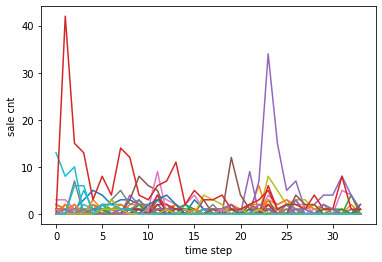

In [8]:
# plot curve

import matplotlib.pyplot as plt

row_random_array = np.arange(data_seq_array.shape[0])
np.random.shuffle(row_random_array)
row_random = data_seq_array[row_random_array][0:100,:,0]
for seq in row_random:
    plt.plot(seq)
plt.xlabel('time step')
plt.ylabel('sale cnt')
plt.show()

In [9]:
# model parameters
cnn_filters = 4
cnn_kernel_size = 2
cnn_strides = 1
rnn_skip = 12
time_steps = data_seq_array.shape[1]-1
pad_len = (time_steps - 1) * cnn_strides + cnn_kernel_size - time_steps
pt = int((time_steps-cnn_kernel_size)/rnn_skip)
ar_window = 34
step_dimension = data_seq_array.shape[2]

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

# # Normalize
# data_seq_norm_array = data_seq_array  # (424124, 34, 5)
# # normalize count data
# sales_mean_array = data_seq_array[:,:,0].mean(axis=1)  # (424124,)
# sales_mean_array = np.where(sales_mean_array==0.,K.epsilon(),sales_mean_array)
# data_seq_norm_array[:,:,0] = data_seq_norm_array[:,:,0]/data_seq_mean_array[:,np.newaxis]
# # normalize price
# price_mean_array = data_seq_array[:,:,1].mean(axis=1)  # (424124,)
# price_mean_array = np.where(price_mean_array==0.,K.epsilon(),price_mean_array)
# data_seq_norm_array[:,:,1] = data_seq_norm_array[:,:,0]/price_mean_array[:,np.newaxis]
# # normalize month
# month_mean = np.mean([i for i in range(0,12)])
# month_var = np.var([i for i in range(0,12)])
# data_seq_norm_array[:,:,4] = (data_seq_norm_array[:,:,4] - month_mean)/month_var

# Split X and Y
X = data_seq_array[:,0:-1,:]
X = np.pad(X, ((0,0),(pad_len,0),(0,0)), 'constant', constant_values=0)  # Note to change the padding accorfing with Conv kernel_size and stride
Y = data_seq_array[:,-1,:]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25)
# input dimension (sale_cnt, shop_id, item_id, month)

In [11]:
# LSTNet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from math import log
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense,GRU, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add
from tensorflow.keras.optimizers import Adam

# model
input_vec = Input(name='input', shape = (X.shape[1], X.shape[2]))
# CNN
conv_vec = Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, strides=cnn_strides, activation='relu', name='cnn')(input_vec)
# RNN
rnn_output_vec, rnn_hidden_state_vec = GRU(4, activation='relu', return_sequences=True, return_state=True, name='rnn')(conv_vec)
rnn_hidden_state_vec = Lambda(lambda k: K.reshape(k, (-1, 4)), name='rnn_output')(rnn_hidden_state_vec)
# RNN-skip
rnn_skip_vec = Lambda(lambda k: k[:, int(-pt*12):, :])(conv_vec)
rnn_skip_vec = Lambda(lambda k: K.reshape(k, (-1, pt, rnn_skip, cnn_filters)))(rnn_skip_vec)
rnn_skip_vec = Lambda(lambda k: K.permute_dimensions(k, (0,2,1,3)))(rnn_skip_vec)
rnn_skip_vec = Lambda(lambda k: K.reshape(k, (-1, pt, cnn_filters)))(rnn_skip_vec)
rnn_skip_output_vec, rnn_skip_hidden_state_vec = GRU(4, activation='relu', return_sequences=True, return_state=True, name='rnn_skip')(rnn_skip_vec)
rnn_skip_hidden_state_vec = Lambda(lambda k: K.reshape(k, (-1, rnn_skip*4)), name='rnn_skip_output')(rnn_skip_hidden_state_vec)
# NN part
nn_vec = Concatenate(axis=1)([rnn_hidden_state_vec, rnn_skip_hidden_state_vec])
nn_vec = Dense(step_dimension, name='nn_output')(nn_vec)
# AR part
ar_vec = Lambda(lambda k: k[:,-ar_window:,:])(input_vec)
ar_vec = Lambda(lambda k: K.permute_dimensions(k, (0,2,1)))(ar_vec)
ar_vec = Lambda(lambda k: K.reshape(k, (-1,ar_window)))(ar_vec)
ar_vec = Dense(1)(ar_vec)
ar_vec = Lambda(lambda k: K.reshape(k, (-1,step_dimension)), name='ar_output')(ar_vec)
# Output
output_vec = Add()([nn_vec, ar_vec])

model = Model(inputs=[input_vec], outputs=[output_vec])
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
model.summary()

history = model.fit(x=X_train, 
                    y=Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=5, 
                    batch_size=1024*1024)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 34, 5)]      0                                            
__________________________________________________________________________________________________
cnn (Conv1D)                    (None, 33, 4)        44          input[0][0]                      
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 24, 4)        0           cnn[0][0]                        
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2, 12, 4)     0           lambda[0][0]                     
______________________________________________________________________________________________

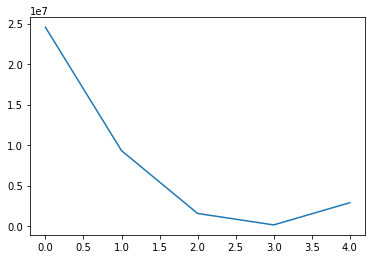

In [12]:
plt.plot(history.history['val_loss'])
plt.show()

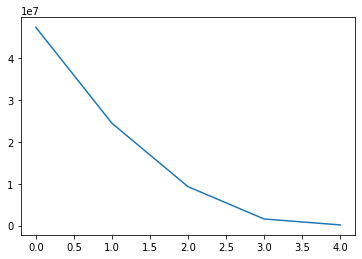

In [13]:
plt.plot(history.history['loss'])
plt.show()

In [14]:
# Prepare Test dataset

test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
test_df['shop_item'] = test_df['shop_id'].astype('string') + '-' + test_df['item_id'].astype('string')

X_test = []
for _, row in test_df.iterrows():
    shop_item = row['shop_item']
    shop_id = row['shop_id']
    item_id = row['item_id']
    if shop_item in data_seq_dict.keys():
        sale_seq = np.array(data_seq_dict[shop_item])[:,0]
        price_seq = np.array(data_seq_dict[shop_item])[:,1]
    elif row['item_id'] in item_seq_dict.keys():
        sale_seq = np.array(item_seq_dict[item_id])[:,0]
        price_seq = np.array(item_seq_dict[item_id])[:,1]
        print('No shop-item', item_id, 'observed in training samples.')
    else:
        sale_seq = np.array([0.0 for i in range(0,34)])
        price_seq = np.array([0.0 for i in range(0,34)])
    shop_id_seq = np.array([float(shop_id) for i in range(len(seq))])
    item_id_seq = np.array([float(item_id) for i in range(len(seq))])
    month_seq = np.array([float(i%12) for i in range(len(seq))])
    X_test.append(np.stack([sale_seq, price_seq, shop_id_seq, item_id_seq, month_seq], axis=1))
X_test = np.stack(X_test, axis=0)
X_test = X_test[:,1:,:]
X_test = np.pad(X_test, ((0,0),(pad_len,0),(0,0)), 'constant', constant_values=0.)

In [15]:
pred = model.predict(X_test)

pred = pred[:,0]
pred = pred.reshape((pred.shape[0]))

In [16]:
# recover the prediction (de-normalized)
pred[pred<0] = 0.0
pred

array([ 1.4655089 ,  0.12628444,  0.65388095, ...,  9.366044  ,
       12.243389  ,  0.        ], dtype=float32)

In [17]:
submission_df = pd.DataFrame(pred, columns=['item_cnt_month'])
submission_df.index.name = 'ID'
submission_df

,item_cnt_month
ID,
0,1.465509
1,0.126284
2,0.653881
3,0.062388
4,0.126284
...,...
214195,13.170648
214196,10.006310
214197,9.366044


In [18]:
submission_df.to_csv('/kaggle/working/submission.csv')